## OCR of 20,000 Synthetic Examples

Dataset Source: https://www.kaggle.com/datasets/ravi02516/20k-synthetic-ocr-dataset

##### Install Necessary Libraries

In [1]:
%pip install torch torchvision torchaudio transformers==4.26.1
%pip install -q datasets jiwer evaluate datasets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 86.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 92.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.8/199.8 KB 25.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 469.0/469.0 KB 23.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.4/81.4 KB 3.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 KB 11.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 62.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.2/212.2 KB 21.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.9/132.9 KB 13.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 87.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.2/114.2 KB 12.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━

#### HuggingFace CLI Login

In [2]:
!huggingface-cli login


    _|    _|  _|    _|    _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|_|_|_|    _|_|      _|_|_|  _|_|_|_|
    _|    _|  _|    _|  _|        _|          _|    _|_|    _|  _|            _|        _|    _|  _|        _|
    _|_|_|_|  _|    _|  _|  _|_|  _|  _|_|    _|    _|  _|  _|  _|  _|_|      _|_|_|    _|_|_|_|  _|        _|_|_|
    _|    _|  _|    _|  _|    _|  _|    _|    _|    _|    _|_|  _|    _|      _|        _|    _|  _|        _|
    _|    _|    _|_|      _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|        _|    _|    _|_|_|  _|_|_|_|
    
    To login, `huggingface_hub` requires a token generated from https://huggingface.co/settings/tokens .
Token: 
Add token as git credential? (Y/n) Y
Token is valid.
Cannot authenticate through git-credential as no helper is defined on your machine.
You might have to re-authenticate when pushing to the Hugging Face Hub.
Run the following command in your terminal in case you want to set the 'store' credential helper as d

##### Import Necessary Libraries

In [3]:
import os, sys, itertools
os.environ['TOKENIZERS_PARALLELISM']='false'

import pandas as pd
import matplotlib.pyplot as plt

from PIL import Image

import torch
from torch.utils.data import Dataset

import datasets
from datasets import load_dataset

import transformers
from transformers import Seq2SeqTrainingArguments, Seq2SeqTrainer
from transformers import VisionEncoderDecoderModel, TrOCRProcessor, default_data_collator

import evaluate

!git lfs install

Error: Failed to call git rev-parse --git-dir: exit status 128 
Git LFS initialized.


#### Mount Google Drive to Notebook

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


##### Display Versions of Relevant Software & Libraries

In [5]:
print("Python:".rjust(15), sys.version[0:6])
print("Pandas:".rjust(15), pd.__version__)
print("Datasets:".rjust(15), datasets.__version__)
print("Transformers:".rjust(15), transformers.__version__)
print("Torch:".rjust(15), torch.__version__)

        Python: 3.9.16
        Pandas: 1.4.4
      Datasets: 2.10.1
  Transformers: 4.26.1
         Torch: 1.13.1+cu116


#### Ingest & Preprocess Training Dataset

In [25]:
parent_dir = "/content/drive/MyDrive/Colab Notebooks/20,000 Synthetic Sample OCR"

train_dataset = pd.read_csv(os.path.join(parent_dir, "train.csv"))

train_dataset = train_dataset.rename(columns={"image name" : "file_name", "label" : "text"})

# Find longest 'text' value (in terms of characters)
longest_text_value = train_dataset['text'].str.len().max()
print("The longest string value for the text feature " +
    f"is {longest_text_value} characters.\n")

print(train_dataset.info())

The longest string value for the text feature is 19 characters.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  20000 non-null  object
 1   text       20000 non-null  object
dtypes: object(2)
memory usage: 312.6+ KB
None


#### Visualize: Histogram of Text Lengths (Training Dataset)

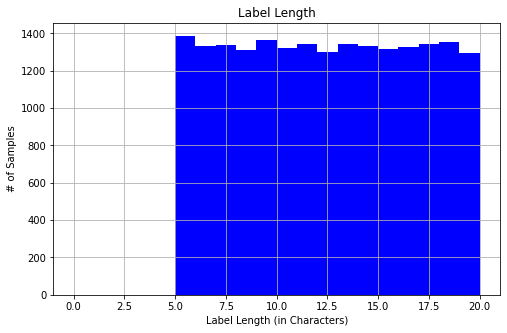

In [26]:
train_dataset['label_len'] = train_dataset['text'].str.len()

max_length_value = 19
train_dataset.hist("label_len", 
             grid=True, 
             color="Blue", 
             figsize=(8,5), 
             bins=max_length_value + 1,
             range=(0, max_length_value + 1)
             )

plt.suptitle('')
plt.xlabel('Label Length (in Characters)')
plt.ylabel('# of Samples')
plt.title('Label Length')
plt.show()


#### Ingest & Preprocess Testing Dataset

In [27]:
test_dataset = pd.read_csv(os.path.join(parent_dir, "test.csv"))

test_dataset = test_dataset.rename(columns={"image name" : "file_name", "label" : "text"})

# Find longest 'text' value (in terms of characters)
longest_text_value = test_dataset['text'].str.len().max()
print("The longest string value for the text feature " +
    f"is {longest_text_value} characters.\n")

print(test_dataset.info())

The longest string value for the text feature is 19 characters.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  5000 non-null   object
 1   text       5000 non-null   object
dtypes: object(2)
memory usage: 78.2+ KB
None


#### Visualize: Histogram of Text Lengths (Testing Dataset)

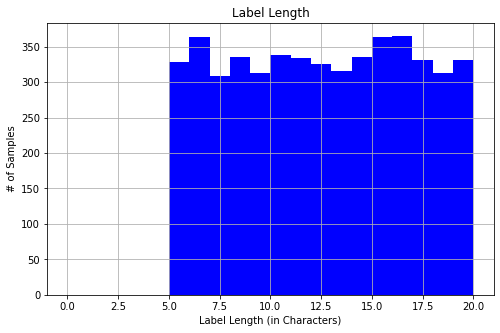

In [28]:
test_dataset['label_len'] = test_dataset['text'].str.len()

test_dataset.hist("label_len", 
             grid=True, 
             color="Blue", 
             figsize=(8,5), 
             bins=max_length_value + 1, 
             range=(0, max_length_value + 1)
             )

plt.suptitle('')
plt.xlabel('Label Length (in Characters)')
plt.ylabel('# of Samples')
plt.title('Label Length')
plt.show()

##### Create Dataset Class

In [29]:
class Synthetic_Dataset_OCR_Dataset(Dataset):
    
    def __init__(self, root_dir, df, processor, max_target_length=128):
        self.root_dir = root_dir
        self.df = df
        self.processor = processor
        self.max_target_length = max_target_length
    
    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        # get file name + text
        file_name = self.df['file_name'][idx]
        text = self.df['text'][idx]
        # prepare image (i.e. resize + normalize)
        image = Image.open(self.root_dir + file_name).convert("RGB")
        pixel_values = self.processor(image, return_tensors="pt").pixel_values
        # add labels (input_ids) by encoding the text
        labels = self.processor.tokenizer(text, padding="max_length", max_length=self.max_target_length).input_ids
        # important: make sure that PAD tokens are ignored by loss function
        labels = [label if label != self.processor.tokenizer.pad_token_id 
                  else -100 for label in labels]
        
        encoding = {"pixel_values" : pixel_values.squeeze(), "labels" : torch.tensor(labels)}
        return encoding

##### Basic Values/Constants

In [30]:
MODEL_CKPT = "microsoft/trocr-base-printed"
MODEL_NAME =  MODEL_CKPT.split("/")[-1] + "-synthetic_dataset_ocr"

NUM_OF_EPOCHS = 1
BATCH_SIZE = 8

REPORTS_TO = "tensorboard"
STRATEGY = "steps"

DEVICE = torch.device("cuda")

##### Instantiate Processor, Create Training, & Testing Dataset Instances

In [31]:
processor = TrOCRProcessor.from_pretrained(MODEL_CKPT)

train_ds = Synthetic_Dataset_OCR_Dataset(root_dir=os.path.join(parent_dir, "files", "20k train/"),
                             df=train_dataset,
                             processor=processor)

test_ds = Synthetic_Dataset_OCR_Dataset(root_dir=os.path.join(parent_dir, "files", "20k test/"),
                             df=test_dataset,
                             processor=processor)

loading configuration file preprocessor_config.json from cache at /root/.cache/huggingface/hub/models--microsoft--trocr-base-printed/snapshots/0c708d318cd981cfc88c217fb90fb769b52ef2ff/preprocessor_config.json
Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration.
size should be a dictionary on of the following set of keys: ({'width', 'height'}, {'shortest_edge'}, {'shortest_edge', 'longest_edge'}), got 384. Converted to {'height': 384, 'width': 384}.
Image processor ViTImageProcessor {
  "do_normalize": true,
  "do_rescale": true,
  "do_resize": true,
  "image_mean": [
    0.5,
    0.5,
    0.5
  ],
  "image_processor_type": "ViTImageProcessor",
  "image_std": [
    0.5,
    0.5,
    0.5
  ],
  "resample": 2,
  "rescale_factor": 0.00392156862745098,
  "size": {
    "height": 384,
    "width": 384
  }
}

loading file vocab.json from cache at /root/.cache/huggingface/hub/m

##### Print Length of Training & Testing Datasets

In [32]:
print(f"The training dataset has {len(train_ds)} samples in it.")
print(f"The testing dataset has {len(test_ds)} samples in it.")

The training dataset has 20000 samples in it.
The testing dataset has 5000 samples in it.


##### Example of Input Data Shapes

In [33]:
encoding = train_ds[8]

for k,v in encoding.items():
    print(k, " : ", v.shape)

pixel_values  :  torch.Size([3, 384, 384])
labels  :  torch.Size([128])


##### Show Example

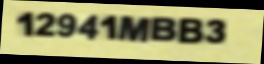

In [34]:
image = Image.open(train_ds.root_dir + train_dataset['file_name'][8]).convert("RGB")

image

##### Show Label for Above Example

In [35]:
labels = encoding['labels']
labels[labels == -100] = processor.tokenizer.pad_token_id
label_str = processor.decode(labels, skip_special_tokens=True)
print(label_str)

12941MBB3


#### Instantiate Model

In [36]:
model = (
    VisionEncoderDecoderModel.from_pretrained(MODEL_CKPT)
    ).to(DEVICE)

loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--microsoft--trocr-base-printed/snapshots/0c708d318cd981cfc88c217fb90fb769b52ef2ff/config.json
Model config VisionEncoderDecoderConfig {
  "_commit_hash": "0c708d318cd981cfc88c217fb90fb769b52ef2ff",
  "architectures": [
    "VisionEncoderDecoderModel"
  ],
  "decoder": {
    "_name_or_path": "",
    "activation_dropout": 0.0,
    "activation_function": "gelu",
    "add_cross_attention": true,
    "architectures": null,
    "attention_dropout": 0.0,
    "bad_words_ids": null,
    "begin_suppress_tokens": null,
    "bos_token_id": 0,
    "chunk_size_feed_forward": 0,
    "classifier_dropout": 0.0,
    "cross_attention_hidden_size": 768,
    "d_model": 1024,
    "decoder_attention_heads": 16,
    "decoder_ffn_dim": 4096,
    "decoder_layerdrop": 0.0,
    "decoder_layers": 12,
    "decoder_start_token_id": 2,
    "diversity_penalty": 0.0,
    "do_sample": false,
    "dropout": 0.1,
    "early_stopping":

##### Model Configuration Modifications

In [37]:
model.config.decoder_start_token_id = processor.tokenizer.cls_token_id
model.config.pad_token_id = processor.tokenizer.pad_token_id

model.config.vocab_size = model.config.decoder.vocab_size

model.config.eos_token_id = processor.tokenizer.sep_token_id
model.config.max_length = max_length_value
model.config.early_stopping = True
model.config.no_repeat_ngram_size = 3
model.config.length_penalty = 0
model.config.num_beams = 8

##### Define Metrics Evaluation

In [38]:
cer_metric = evaluate.load("cer")

def compute_metrics(pred):
    label_ids = pred.label_ids
    pred_ids = pred.predictions
    
    pred_str = processor.batch_decode(pred_ids, skip_special_tokens=True)
    label_ids[label_ids == -100] = processor.tokenizer.pad_token_id
    label_str = processor.batch_decode(label_ids, skip_special_tokens=True)
    
    cer = cer_metric.compute(predictions=pred_str, references=label_str)
    
    return {"cer" : cer}

#### Define Training Arguments

In [39]:
args = Seq2SeqTrainingArguments(
    output_dir = MODEL_NAME,
    num_train_epochs=NUM_OF_EPOCHS,
    predict_with_generate=True,
    evaluation_strategy=STRATEGY,
    save_strategy=STRATEGY,
    logging_strategy=STRATEGY,
    logging_steps=100,
    logging_first_step=True,
    eval_steps=10000,
    save_steps=300,
    report_to=REPORTS_TO,
    per_device_train_batch_size=BATCH_SIZE,
    per_device_eval_batch_size=BATCH_SIZE,
    fp16=True,
    hub_private_repo=True,
    push_to_hub=True
)

PyTorch: setting up devices


##### Define Trainer

In [40]:
trainer = Seq2SeqTrainer(
    model=model,
    tokenizer=processor.feature_extractor,
    args=args,
    compute_metrics=compute_metrics,
    train_dataset=train_ds,
    eval_dataset=test_ds,
    data_collator=default_data_collator
)

/usr/local/lib/python3.9/dist-packages/transformers/models/trocr/processing_trocr.py:134: FutureWarning: `feature_extractor` is deprecated and will be removed in v5. Use `image_processor` instead.
  warnings.warn(
/content/trocr-base-printed-synthetic_dataset_ocr is already a clone of https://huggingface.co/DunnBC22/trocr-base-printed-synthetic_dataset_ocr. Make sure you pull the latest changes with `repo.git_pull()`.
Using cuda_amp half precision backend


##### Fit/Train Model

In [41]:
train_results = trainer.train()

/usr/local/lib/python3.9/dist-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 20000
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 2500
  Number of trainable parameters = 333921792


Step,Training Loss,Validation Loss


Saving model checkpoint to trocr-base-printed-synthetic_dataset_ocr/checkpoint-300
Configuration saved in trocr-base-printed-synthetic_dataset_ocr/checkpoint-300/config.json
Configuration saved in trocr-base-printed-synthetic_dataset_ocr/checkpoint-300/generation_config.json
Model weights saved in trocr-base-printed-synthetic_dataset_ocr/checkpoint-300/pytorch_model.bin
Image processor saved in trocr-base-printed-synthetic_dataset_ocr/checkpoint-300/preprocessor_config.json
Image processor saved in trocr-base-printed-synthetic_dataset_ocr/preprocessor_config.json
Saving model checkpoint to trocr-base-printed-synthetic_dataset_ocr/checkpoint-600
Configuration saved in trocr-base-printed-synthetic_dataset_ocr/checkpoint-600/config.json
Configuration saved in trocr-base-printed-synthetic_dataset_ocr/checkpoint-600/generation_config.json
Model weights saved in trocr-base-printed-synthetic_dataset_ocr/checkpoint-600/pytorch_model.bin
Image processor saved in trocr-base-printed-synthetic_dat

##### Save Model & Training Metrics

In [42]:
trainer.save_model()
trainer.log_metrics("train", train_results.metrics)
trainer.save_metrics("train", train_results.metrics)
trainer.save_state()

Saving model checkpoint to trocr-base-printed-synthetic_dataset_ocr
Configuration saved in trocr-base-printed-synthetic_dataset_ocr/config.json
Configuration saved in trocr-base-printed-synthetic_dataset_ocr/generation_config.json
Model weights saved in trocr-base-printed-synthetic_dataset_ocr/pytorch_model.bin
Image processor saved in trocr-base-printed-synthetic_dataset_ocr/preprocessor_config.json
Saving model checkpoint to trocr-base-printed-synthetic_dataset_ocr
Configuration saved in trocr-base-printed-synthetic_dataset_ocr/config.json
Configuration saved in trocr-base-printed-synthetic_dataset_ocr/generation_config.json
Model weights saved in trocr-base-printed-synthetic_dataset_ocr/pytorch_model.bin
Image processor saved in trocr-base-printed-synthetic_dataset_ocr/preprocessor_config.json


Upload file pytorch_model.bin:   0%|          | 1.00/1.24G [00:00<?, ?B/s]

Upload file runs/Mar27_15-41-31_3a7d191b4b75/events.out.tfevents.1679931698.3a7d191b4b75.183.2:   0%|         …

To https://huggingface.co/DunnBC22/trocr-base-printed-synthetic_dataset_ocr
   6c120da..cc7c9a6  main -> main

   6c120da..cc7c9a6  main -> main

To https://huggingface.co/DunnBC22/trocr-base-printed-synthetic_dataset_ocr
   cc7c9a6..da1815e  main -> main

   cc7c9a6..da1815e  main -> main



***** train metrics *****
  epoch                    =           1.0
  total_flos               = 13937897812GF
  train_loss               =        0.3502
  train_runtime            =    4:58:03.06
  train_samples_per_second =         1.118
  train_steps_per_second   =          0.14


##### Push Model to Hub (My Profile!!!)

In [43]:
kwargs = {
    "finetuned_from" : model.config._name_or_path,
    "tasks" : "image-to-text",
    "tags" : ["image-to-text"],
}

if args.push_to_hub:
    trainer.push_to_hub("All Dunn!!!")
else:
    trainer.create_model_card(**kwargs)

Saving model checkpoint to trocr-base-printed-synthetic_dataset_ocr
Configuration saved in trocr-base-printed-synthetic_dataset_ocr/config.json
Configuration saved in trocr-base-printed-synthetic_dataset_ocr/generation_config.json
Model weights saved in trocr-base-printed-synthetic_dataset_ocr/pytorch_model.bin
Image processor saved in trocr-base-printed-synthetic_dataset_ocr/preprocessor_config.json
To https://huggingface.co/DunnBC22/trocr-base-printed-synthetic_dataset_ocr
   da1815e..4d72540  main -> main

   da1815e..4d72540  main -> main



##### Evaluate Model

In [ ]:
metrics = trainer.evaluate()
trainer.log_metrics("eval", metrics)
trainer.save_metrics("eval", metrics)

***** Running Evaluation *****
  Num examples = 5000
  Batch size = 8
Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "early_stopping": true,
  "eos_token_id": 2,
  "length_penalty": 0,
  "max_length": 19,
  "no_repeat_ngram_size": 3,
  "num_beams": 8,
  "pad_token_id": 1,
  "transformers_version": "4.26.1"
}

/usr/local/lib/python3.9/dist-packages/transformers/generation/utils.py:1186: UserWarning: You have modified the pretrained model configuration to control generation. This is a deprecated strategy to control generation and will be removed soon, in a future version. Please use a generation configuration file (see https://huggingface.co/docs/transformers/main_classes/text_generation)
  warnings.warn(


Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "early_stopping": true,
  "eos_token_id": 2,
  "length_penalty": 0,
  "max_length": 19,
  "no_repeat_ngram_size": 3,
  "num_beams": 8,
  "pad_token_id": 1,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "early_stopping": true,
  "eos_token_id": 2,
  "length_penalty": 0,
  "max_length": 19,
  "no_repeat_ngram_size": 3,
  "num_beams": 8,
  "pad_token_id": 1,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "early_stopping": true,
  "eos_token_id": 2,
  "length_penalty": 0,
  "max_length": 19,
  "no_repeat_ngram_size": 3,
  "num_beams": 8,
  "pad_token_id": 1,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "early_stopping": true,
  "eos_token_id": 2,
  "length_penalty": 0,
  "max_length": 19,
  "no_repeat_ngram_size": 3,
  "num_beams": 8,
  "pad_toke

### Notes & Other Takeaways From This Project
****
- I aim to learn something new from every project. In this project, I learned how to train and evaluate a model in a separate sessions.
****

### Citations

- Model Checkpoint
  > @misc{li2021trocr, title={TrOCR: Transformer-based Optical Character Recognition with Pre-trained Models}, author={Minghao Li and Tengchao Lv and Lei Cui and Yijuan Lu and Dinei Florencio and Cha Zhang and Zhoujun Li and Furu Wei}, year={2021}, eprint={2109.10282}, archivePrefix={arXiv}, primaryClass={cs.CL}
}

- Metric (Character Error Rate [CER])
  > @inproceedings{morris2004,
author = {Morris, Andrew and Maier, Viktoria and Green, Phil},
year = {2004},
month = {01},
pages = {},
title = {From WER and RIL to MER and WIL: improved evaluation measures for connected speech recognition.}
}